# EfficientNetB6-based CNN model

## Set working directory

In [ ]:
from google.colab import drive

drive.mount('/gdrive')
%cd /gdrive/My Drive/ # Set your directory

In [ ]:
%%writefile requirements.txt # These are needed to match libraries versions on Colab
tensorflow==2.17.0
keras==3.4.1
pip install -r requirements.txt

In [ ]:
# Define model name:
model_name = 'EfficientNetB6_tuned'

## Import libraries

In [ ]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os
import setuptools.dist

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np
from tqdm.auto import tqdm

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import regularizers

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
from PIL import Image
import matplotlib.gridspec as gridspec

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

2.17.0


## Load data and split

In [9]:
import zipfile
from io import BytesIO

# Path to the zip file
zip_path = "../../datasets.zip"

# Open the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    # List all files in the zip archive
    file_names = zip_ref.namelist()
    print("Files in the zip archive:", file_names)

    # Load each .npz file
    datasets = {}
    for file_name in file_names:
        if file_name.endswith(".npz"):  # Ensure it's a .npz file
            with zip_ref.open(file_name) as npz_file:
                # Copy the file content into memory
                npz_data = BytesIO(npz_file.read())
                datasets[file_name] = np.load(npz_data)

    # Access the loaded data
    train_data = datasets["train.npz"]
    test_data = datasets["test.npz"]
    val_data = datasets["val.npz"]

X_train = train_data["images"]
y_train = train_data["labels"]

X_test = test_data["images"]
y_test = test_data["labels"]

X_val = val_data["images"]
y_val = val_data["labels"]

del train_data, test_data, val_data, datasets

# Define the mapping for the labels
label_names = {
    0: "Basophil",
    1: "Eosinophil",
    2: "Erythroblast",
    3: "Immature granulocytes",
    4: "Lymphocyte",
    5: "Monocyte",
    6: "Neutrophil",
    7: "Platelet"
}

# Input shape for the model
input_shape = X_train.shape[1:]

# Output shape for the model
output_shape = y_train.shape[1]


Files in the zip archive: ['train.npz', 'val.npz', 'test.npz']


# Model

## Build the Model

In [ ]:
# Set the hyperparameters

# Number of training epochs
epochs = 150

# patience
patience = 20

# Batch size for training
batch_size = 128

# Learning rate: step size for updating the model's weights
learning_rate = 1e-4

# number of fine-tunable layer
num_layers_to_unfreeze = 20

In [ ]:
# Initialize the EfficientNetB5 model
efficientnet_model = tf.keras.applications.EfficientNetB6(
    input_shape=(528, 528, 3),   # Input shape for EfficientNetB5
    include_top=False,           # Exclude the fully connected layer for feature extraction
    weights='imagenet'           # Use pre-trained weights from ImageNet
)

165234480/165234480 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
def build_model(
    input_shape = input_shape,
    output_shape = output_shape,
    learning_rate = learning_rate,
    seed = seed
):
  tf.random.set_seed(42)

  # Define input layer
  inputs = tf.keras.Input(shape=input_shape, name='input')
  x = tfkl.Resizing(528, 528)(inputs)

  # EfficientNet transfer learning
  x = tfk.applications.efficientnet.preprocess_input(x)


  # Unfreeze the last 'num_layers_to_unfreeze' convolutional layers
  for layer in efficientnet_model.layers:
      layer.trainable = False

  trainable = num_layers_to_unfreeze

  conv_count = 0
  last_unfrozen_conv_idx = -1
  for i, layer in enumerate(reversed(efficientnet_model.layers)):
      if '_conv' in layer.name:
         if conv_count <= trainable :
            layer.trainable = True
            conv_count += 1
            last_unfrozen_conv_idx = len(efficientnet_model.layers) - 1 - i
         else:
            break

  if False:
     for i, layer in enumerate(efficientnet_model.layers[last_unfrozen_conv_idx + 1:], start=last_unfrozen_conv_idx + 1):
         if '_bn' in layer.name:
            layer.trainable = True


  x = efficientnet_model(x)

  x = tfkl.GlobalAveragePooling2D()(x)
  x = tfkl.BatchNormalization()(x)
  x = tfkl.Dropout(0.3)(x)

 # Dense layers
  x = tfkl.Dense(units=1024,activation='relu',kernel_regularizer=regularizers.l2(1e-5))(x)
  x = tfkl.Dropout(0.3)(x)
  x = tfkl.BatchNormalization()(x)

  x = tfkl.Dense(units=128,activation='relu',kernel_regularizer=regularizers.l2(1e-5))(x)
  x = tfkl.Dropout(0.3)(x)
  x = tfkl.BatchNormalization()(x)

  # Add final Dense layer for classification with softmax activation
  outputs = tfkl.Dense(output_shape, activation='softmax')(x)

  # Create the complete Model linking input and output
  model = tfk.Model(inputs=inputs, outputs=outputs, name='EfficientNetB6_model')

  # Compile the model
  loss = tfk.losses.CategoricalCrossentropy()
  optimizer = tfk.optimizers.Adam(learning_rate=learning_rate)
  metrics = ['accuracy']
  model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

  return model

In [ ]:
# Trace the weights' update
best_model_weights = tfk.callbacks.ModelCheckpoint(
    filepath = "./EN6/checkpoint.weights.h5",
    monitor='val_accuracy',
    mode = 'max',
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    save_freq="epoch"
)

# Create an EarlyStopping callback
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=patience,
    restore_best_weights=True
)

# Reduce the learning rate on plateu
learn_rate_reg = tfk.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1, patience=15,
    min_delta=1e-5
)

# Store the callback in a list
callbacks = [early_stopping, best_model_weights,learn_rate_reg]

In [ ]:
model = build_model()

# Display a summary of the model architecture
model.summary(expand_nested=False)

# Display model architecture with layer shapes and trainable parameters
# tfk.utils.plot_model(model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

Model: "EfficientNetB6_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)                   │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resizing (Resizing)                  │ (None, 528, 528, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb6 (Functional)          │ (None, 17, 17, 2304)        │      40,960,143 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2304)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 2304)                │           9,216 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │       2,360,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 8)                   │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 43,466,519 (165.81 MB)

 Trainable params: 23,628,296 (90.13 MB)

 Non-trainable params: 19,838,223 (75.68 MB)

## Training

In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_val, y_val),
    # class_weight = class_weights_dict,
    callbacks = callbacks
).history


# Calculate and print the final validation accuracy
final_val_accuracy = round(max(history['val_accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

Epoch 1/150
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 745ms/step - accuracy: 0.6062 - loss: 1.2725
Epoch 1: val_accuracy improved from -inf to 0.88215, saving model to ./EN6/checkpoint.weights.h5
365/365 ━━━━━━━━━━━━━━━━━━━━ 451s 928ms/step - accuracy: 0.6065 - loss: 1.2716 - val_accuracy: 0.8821 - val_loss: 0.4053 - learning_rate: 1.0000e-04
Epoch 2/150
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 546ms/step - accuracy: 0.8455 - loss: 0.5717
Epoch 2: val_accuracy improved from 0.88215 to 0.90853, saving model to ./EN6/checkpoint.weights.h5
365/365 ━━━━━━━━━━━━━━━━━━━━ 209s 573ms/step - accuracy: 0.8455 - loss: 0.5716 - val_accuracy: 0.9085 - val_loss: 0.3001 - learning_rate: 1.0000e-04
Epoch 3/150
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 546ms/step - accuracy: 0.8790 - loss: 0.4670
Epoch 3: val_accuracy improved from 0.90853 to 0.91557, saving model to ./EN6/checkpoint.weights.h5
365/365 ━━━━━━━━━━━━━━━━━━━━ 212s 582ms/step - accuracy: 0.8790 - loss: 0.4669 - val_accuracy: 0.9156 - val_loss: 0.2732 - learning_rate: 

In [ ]:
# Save the trained model to a file with the accuracy included in the filename
model_filename = model_name + '_' + str(final_val_accuracy)+'.keras'
model.save(model_filename)

# Delete the model to free up resources
del model

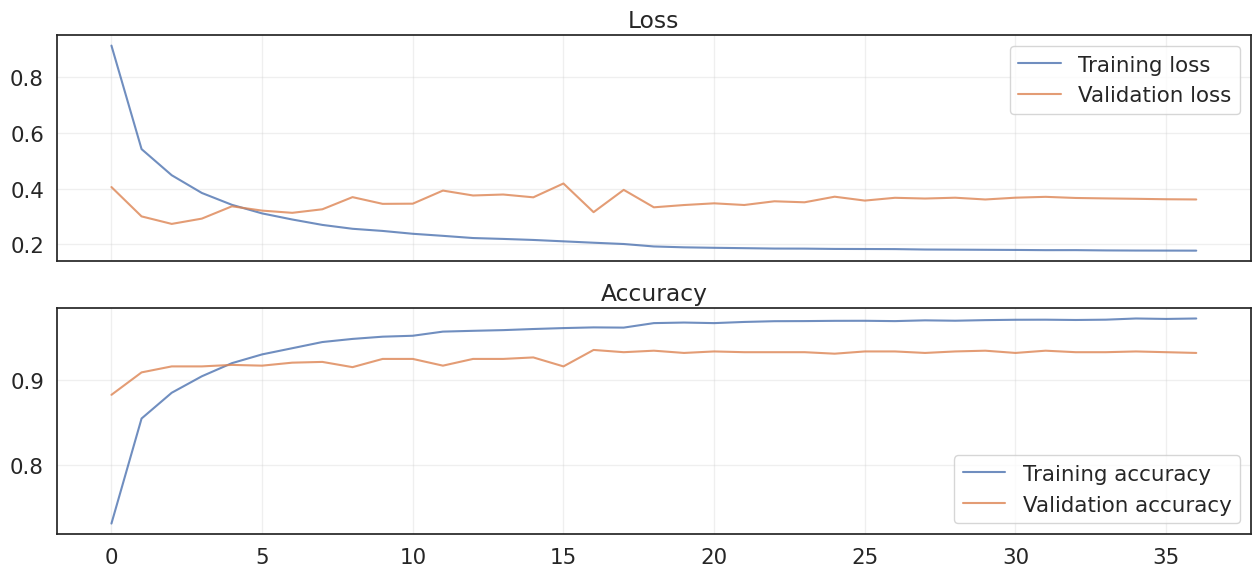

In [ ]:
# Create figure and subplots for loss and accuracy
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 6), sharex=True)

# Plot training and validation loss
ax1.plot(history['loss'], label='Training loss', alpha=.8)
ax1.plot(history['val_loss'], label='Validation loss', alpha=.8)
ax1.set_title('Loss')
ax1.legend()
ax1.grid(alpha=.3)

# Plot training and validation accuracy
ax2.plot(history['accuracy'], label='Training accuracy', alpha=.8)
ax2.plot(history['val_accuracy'], label='Validation accuracy', alpha=.8)
ax2.set_title('Accuracy')
ax2.legend()
ax2.grid(alpha=.3)

# Adjust the layout and display the plot
plt.tight_layout()
plt.subplots_adjust(right=0.85)
plt.show()

## Testing

Predictions Shape: (598, 8)
Accuracy score over the test set: 0.9448
Precision score over the test set: 0.9458
Recall score over the test set: 0.9448
F1 score over the test set: 0.9447


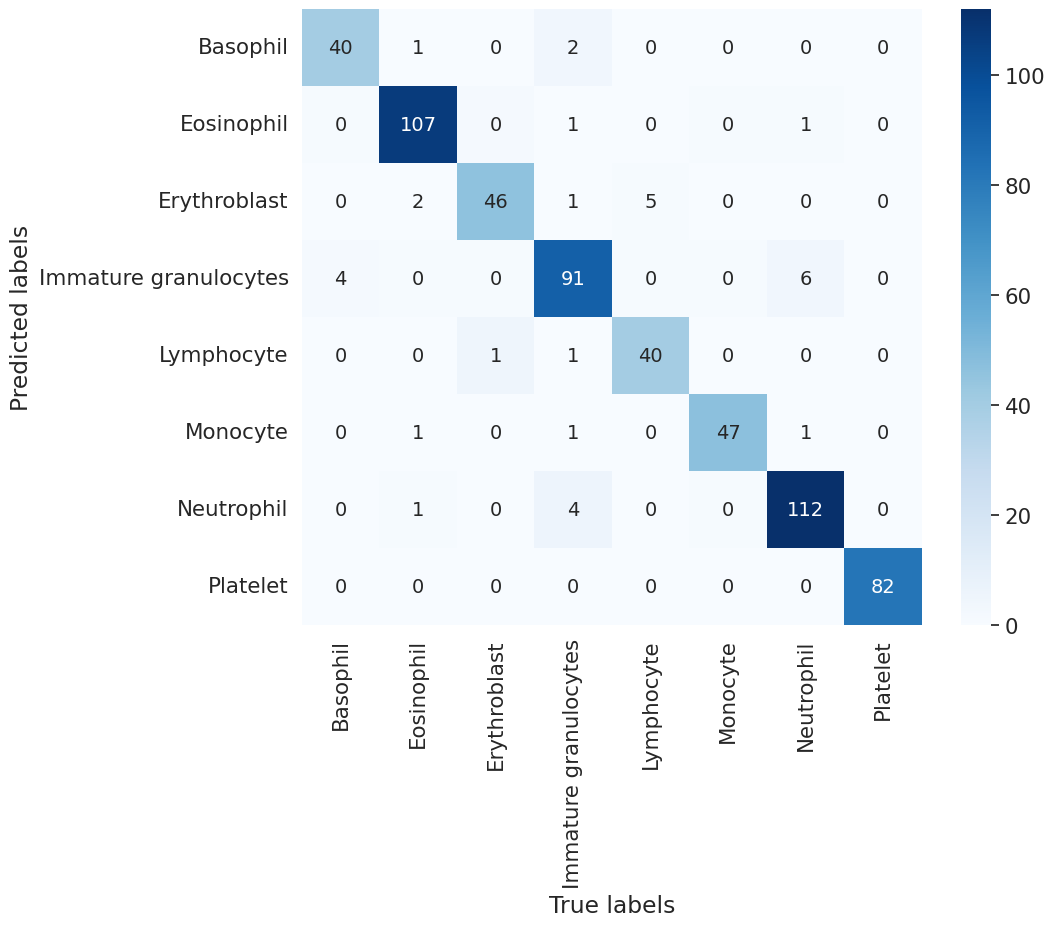

In [10]:
# Load the saved model
model = tfk.models.load_model(model_filename)

# Predict labels for the entire test set
predictions = model.predict(X_test, verbose=0)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)

# Convert predictions to class labels
pred_classes = np.argmax(predictions, axis=-1)

# Extract ground truth classes
true_classes = np.argmax(y_test, axis=-1)

# Calculate and display test set accuracy
accuracy = accuracy_score(true_classes, pred_classes)
print(f'Accuracy score over the test set: {round(accuracy, 4)}')

# Calculate and display test set precision
precision = precision_score(true_classes, pred_classes, average='weighted')
print(f'Precision score over the test set: {round(precision, 4)}')

# Calculate and display test set recall
recall = recall_score(true_classes, pred_classes, average='weighted')
print(f'Recall score over the test set: {round(recall, 4)}')

# Calculate and display test set F1 score
f1 = f1_score(true_classes, pred_classes, average='weighted')
print(f'F1 score over the test set: {round(f1, 4)}')

# Compute the confusion matrix
cm = confusion_matrix(true_classes, pred_classes)

# Combine numbers and percentages into a single string for annotation
annot = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, annot=annot, fmt='', xticklabels=list(label_names.values()), yticklabels=list(label_names.values()), cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()